# Linear-nonlinear coupled problem with non-linear diffusion

## This script contains the following: 

* Models a linear-nonlinear coupled problem with non-linear diffusion
* Solves the problem using FEM
* Constructs the hybrid-NL and surrogate-NL
* Gives performance results regarding relative error and computation time

## Problem description

Consider the unit square domain $\Omega=(0,1)\times (0,1)$ with $\overline{\Omega}=\overline{\Omega_1\cup \Omega_2}$ such that the domain is horizontally split into two equal parts, that is
\begin{gather*}
    \Omega_1 = \{ (x,y) \ | \ x \in \Omega \ \land \ 0.5 < y < 1 \}, \quad
    \Omega_2 = \{ (x,y) \ | \ x \in \Omega \ \land \ 0 < y < 0.5 \}. 
\end{gather*}    
The boundary is given by $\overline{\partial \Omega}=\overline{\Gamma_T \cup \Gamma_B \cup \Gamma_L \cup \Gamma_R}$, that is top, bottom, left and right boundary respectively. Let $\mathcal{N}_L$ be a linear operator resembling linear diffusion so that
\begin{align}
    \label{eq:operators}
    \mathcal{N}_L u &= - \nabla \cdot (\tilde{k}({x})\nabla u) \quad \text{with} \quad     \tilde{k}({x}) = \sum_{i=1}^2 \mathbb{1}_{\Omega_i}({x}).
\end{align}
The linear parametrized Poisson problem is given by
\begin{gather}
\label{eq:poissonlinear}
    \begin{cases}
        - \mathcal{N}_Lu = f({x};{\mu}) & \text{in} \ \ \ \Omega, \\
        u= 1 & \text{on} \ \ \ \Gamma_L \cup \Gamma_R, \\
    \frac{\partial u}{\partial {n}} = 1 & \text{on} \ \ \ \Gamma_T , \\
    \frac{\partial u}{\partial {n}} = -1 & \text{on} \ \ \ \Gamma_B,
    \end{cases}
\end{gather}
with outward unit normal ${n}$ and
\begin{align}
     f({x},{\mu}) = \mathbb{1}_{\Omega_2}({x}) \ 100 \ \text{exp}\left(0.5\left(\frac{(x-\mu_1)^2+(y-\mu_2)^2}{\mu_3}\right)^2\right) 
\label{eq:numpoisson3}
\end{align}
with ${\mu} \in \mathcal{P} = [0, 1]\times[0, \ 0.5]\times[0.001, \ 0.1]$. The source term describes a Gaussian-like function that varies in position and intensity on domain $\Omega_2$. The goal is to solve the problem over the whole parameter space. \\ \\

# Import libraries and load functions

In [2]:
%run functions.ipynb

# Sample FOM solution

Generating snapshots
1 snapshots computed, 0 snapshots to go...
 Finished.


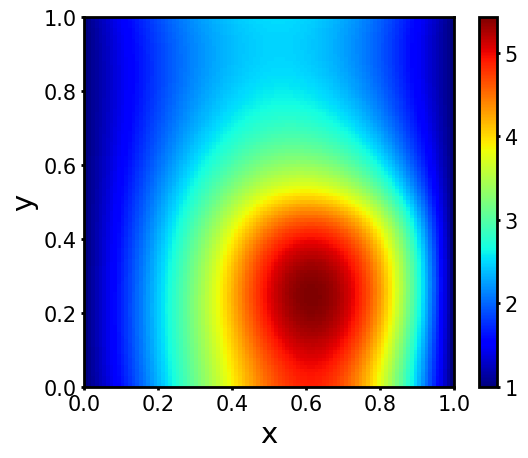

In [3]:
# Choose number of snapshots and test samples
ntest = 0
nsamples = 1 + ntest

start = time.time()
%run FOM_snapshots_LL_P1.ipynb
end = time.time()

online_FOM = end - start 

U_to_figure(U,rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)

# Offline stage

# Create FOM snapshots and 100 test samples

In [4]:
# Choose number of snapshots and test samples
ntest = 100
nsamples = 500 + ntest

alreadyrun = 1

if not alreadyrun:
    %run FOM_snapshots_LL_P1.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_1I, A_11, A_II1, F_1, mu, F_2I_array, f_I, snapshots_time]

    with open('offline_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_1I, A_11, A_II1, F_1, mu, F_2I_array, f_I, snapshots_time = pickle.load(file)

# Perform POD analysis

Snapshot energy domain 1: 0.9983769355755766
Snapshot energy domain 2: 0.939404327654718
Snapshot energy interface: 0.9948292931577204


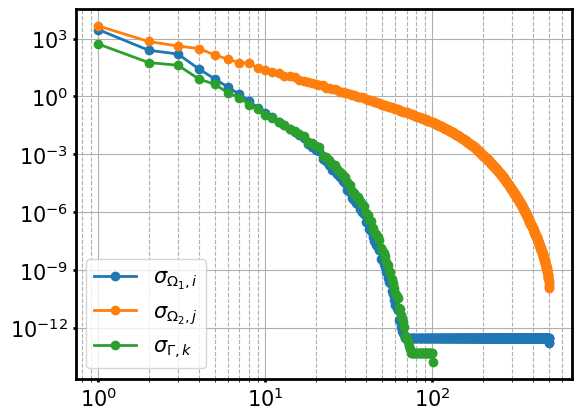

In [5]:
# Choose number of modes

cutoff1 = 5
cutoffI = 5
cutoff2 = 5

V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2, = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)

# Create hybrid solutions for hybrid-LL and surrogate-LL

In [6]:
alreadyrun = 1

if not alreadyrun:
    %run Hybrid_snapshots_LL_P1.ipynb

    # Open a file and use dump()
    variables = [s, traction_array12, u_I_list, a1_tilde, f1_tilde, hybridtime]

    with open('hybrid_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('hybrid_vars.pkl', 'rb') as file:

        # Call load method
        s, traction_array12, u_I_list, a1_tilde, f1_tilde, hybridtime = pickle.load(file)

# Generate $\tilde{\mathcal{T}}_{n_s}$ and $\{ t_\Gamma(\mu^i)  \}_{i=1}^{n_s}$

In [7]:
start = time.time()

traction_array34 = np.zeros((nsamples,ndofs_uI))

# Compute the traction force
for i in range(nsamples):
    
    print(i+1, "traction forces computed,",nsamples-i-1,"to go...", end="\r")
    if i == 0:
        a_II1 = np.matmul(np.matmul(V_I.T, A_II1.toarray()), V_I)
        a_I1 = np.matmul(np.matmul(V_I.T, A_I1.toarray()), V_1)
        a_1I = np.matmul(np.matmul(V_1.T,A_1I.toarray()),V_I)

        a_11 = np.matmul(np.matmul(V_1.T,A_11.toarray()),V_1)
        f_1 = np.matmul(V_1.T,F_1)
        f_1I = np.matmul(V_I.T,F_1I)

        a1_tilde34 = a_II1-np.matmul(np.matmul(a_I1,np.linalg.inv(a_11)),a_1I)
        f1_tilde34 = np.matmul(np.matmul(a_I1,np.linalg.inv(a_11)),f_1)-f_1I

    traction = np.matmul(a1_tilde,uI[i])+f1_tilde
    
    traction_array34[i] = traction
    
    if i == nsamples-ntest:
        end = time.time()
    

m3_partial_time = end - start

# Train separate neural networks $\hat{\pi}^{(i)}_2$ for $i=1,2,...,n_2$ for hybrid-LL and surrogate-LL

In [8]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()

    # In the snapshot matrix we take the dofs on domain 2
    s_train = s[:,0:nsamples-ntest]

    s_2 = s_train[ndofs_u1:ndofs_u1+ndofs_U2]
    V_2_hybrid, svs_2 = POD2(s_2,cutoff2,0)

    ndofs_u2 = np.shape(V_2_hybrid)[1]
    
    nmodes = 1
    n_epochs = 1000
    learning_rate = 0.03
    torch_inputs = torch.from_numpy(np.concatenate((u_I_list[0:nsamples-ntest], mu[0:nsamples-ntest]), axis=1)).float()

    u_2_models12 = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.003
        if i == 6:
            n_epochs = 500

        torch_outputs = get_outputs(s_2,V_2_hybrid[:,i*nmodes:i*nmodes+nmodes],0)
        
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models12.append(u_2_model)
        
    end = time.time()
    time_u2_12 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models12, time_u2_12, V_2_hybrid]

    with open('u_2_models12.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models12.pkl', 'rb') as file:

        # Call load method
        u_2_models12, time_u2_12, V_2_hybrid = pickle.load(file)

# Train neural network $\hat{t}_\Gamma$ for hybrid-LL

In [9]:
alreadyrun = 1

if not alreadyrun:

    traction_output = (traction_array12[:nsamples-ntest])

    # Train NN for traction force
    torch_inputs = get_inputs(mu[0:nsamples-ntest,:],u_I_list[0:nsamples-ntest],0)

    traction_torch_outputs = torch.from_numpy(traction_output).float()

    n_epochs = 1000 
    learning_rate = 0.0005

    print("Trianing a Neural Network for the traction force...")
    traction_model12, NNtraction, loss = Neural_Network(torch_inputs, traction_torch_outputs, n_epochs, learning_rate)
    
    # Open a file and use dump()
    variables = [traction_model12, NNtraction]

    with open('traction_model12.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('traction_model12.pkl', 'rb') as file:

        # Call load method
        traction_model12, traction_time12 = pickle.load(file)

# Train neural network for $\hat{\pi}_\Gamma$ for surrogate-LL

In [10]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.003

    torch_outputs = torch.from_numpy(u_I_list[0:nsamples-ntest,:]).float()
    uI_model2, uI_model2time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    variables = [uI_model2, uI_model2time]

    with open('ugamma2.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma2.pkl', 'rb') as file:

        # Call load method
        uI_model2, uI_model2time = pickle.load(file)

# Train separate neural networks $\hat{\pi}^{(i)}_2$ for $i=1,2,...,n_2$ for hybrid-NL and surrogate-NL

In [11]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()
    
    nmodes = 1
    n_epochs = 1000
    
    learning_rate = 0.03
    torch_inputs = torch.from_numpy(np.concatenate((uI[0:nsamples-ntest], mu[0:nsamples-ntest]), axis=1)).float()

    u_2_models34 = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.003
        if i == 6:
            n_epochs = 500

        torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
        
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models34.append(u_2_model)
        
    end = time.time()
    time_u2_34 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models34, time_u2_34]

    with open('u_2_models34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models34.pkl', 'rb') as file:

        # Call load method
        u_2_models34, time_u2_34 = pickle.load(file)

# Train neural network $\hat{t}_\Gamma$ for hybrid-NL

In [12]:
alreadyrun = 1

if not alreadyrun:

    traction_output = (traction_array34[:nsamples-ntest])

    # Train NN for traction force
    torch_inputs = get_inputs(mu[0:nsamples-ntest,:],uI[0:nsamples-ntest],0)

    traction_torch_outputs = torch.from_numpy(traction_output).float()

    n_epochs = 1000 # 1000
    learning_rate = 0.0005

    print("Trianing a Neural Network for the traction force...")
    traction_model34, traction_time34, loss = Neural_Network(torch_inputs, traction_torch_outputs, n_epochs, learning_rate)
    
    # Open a file and use dump()
    variables = [traction_model34, traction_time34]

    with open('traction_model34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('traction_model34.pkl', 'rb') as file:

        # Call load method
        traction_model34, traction_time34 = pickle.load(file)

# Train neural network for $\hat{\pi}_\Gamma$ for surrogate-NL

In [13]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.001

    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:]).float()

    uI_model4, uI_model4time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    
    variables = [uI_model4, uI_model4time]


    with open('ugamma4.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma4.pkl', 'rb') as file:

        # Call load method
        uI_model4, uI_model4time = pickle.load(file)

# Online stage

# Hybrid-LL

In [16]:
h = 1e-5
threshold = 1e-7
gamma = 1e-1

# Loop through test samples

nmodes = 1
rel_d1_m1 = np.zeros((ntest))
rel_d2_m1 = np.zeros((ntest))

rel_dI_m1 = np.zeros((ntest))
rel_all_m1 = np.zeros((ntest))
online_m1 = np.zeros((ntest))

sol_m1 = np.zeros((ntest,np.size(S[:,1])))

    
for j in range(ntest):
    print("Online stage: test sample",j,end="\r")
    which = nsamples-ntest+j

    mu_test = mu[which]
    
    uI_exact = u_I_list[which]
    
    start = time.time()

    # Determine the reduced vector on the interface
    initial, norm, mu_start = find_initial_condition(mu, mu_test, u_I_list, nsamples, ntest)
    u_I_pred_m1, delta_norm, fk, count, residuals = newdescent(initial, mu_test, h, gamma, a1_tilde, f1_tilde, threshold, traction_model12)


    # Determine the reduced vector on domain 2
    u_2_pred = []

    for i in range(int(cutoff2/nmodes)):

        mode = u_2_models12[i](torch.from_numpy(np.hstack((u_I_pred_m1,mu_test))).float()).detach().numpy()
        u_2_pred.append(mode[0])
        
        
    u_2_predh = np.matmul(V_2_hybrid,u_2_pred)
    
    u_I_predh = np.matmul(V_I,u_I_pred_m1)
    u_1_pred = np.matmul(np.linalg.inv(a_11),f_1-np.matmul(a_1I,u_I_pred_m1))
    u_1_predh = np.matmul(V_1,u_1_pred)

    U_pred = np.hstack((u_1_predh,u_2_predh,u_I_predh))
    
    end = time.time()
    online_iter = end - start
    online_m1[j] = online_iter
    
    # Calculate relative errors
    U_exact = S[:,which]

    rel_error_1_1 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
    rel_error_2_1 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
    rel_error_I_1 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])

    rel_error_total_1 = relative_error(U_exact,U_pred)
    
    # Save solutions
    sol_m1[j] = U_pred
    
    # Save errors
    rel_d1_m1[j] = rel_error_1_1
    rel_d2_m1[j] = rel_error_2_1
    rel_dI_m1[j] = rel_error_I_1
    
    rel_all_m1[j] = rel_error_total_1

# Surrogate-LL

In [17]:
rel_d1_m2 = np.zeros((ntest))
rel_d2_m2 = np.zeros((ntest))

rel_dI_m2 = np.zeros((ntest))
rel_all_m2 = np.zeros((ntest))

online_m2 = np.zeros((ntest))
sol_m2 = np.zeros((ntest,np.size(S[:,1])))


for j in range(ntest):
    print("Online stage: test sample",j,end="\r")

    start = time.time()
    which = nsamples-ntest+j

    mu_test = mu[which]
    
    u_I_pred_m2 = uI_model2(torch.from_numpy(mu_test).float()).detach().numpy()    
    u_I_predh_m2 = np.matmul(V_I,u_I_pred_m2)
    
    # Compare to real solution
    uI_exact = u_I_list[which]
    
    u_2_pred_m2 = []

    # collect relative errors domain 2
    samples2 = []

    for i in range(int(cutoff2/nmodes)):
        
        # method 2
        mode2 = u_2_models12[i](torch.from_numpy(np.hstack((u_I_pred_m2,mu_test))).float()).detach().numpy()
        u_2_pred_m2.append(mode2[0])
        
    u_2_predh_m2 = np.matmul(V_2_hybrid,u_2_pred_m2)
    
    u_1_pred = np.matmul(np.linalg.inv(a_11),f_1-np.matmul(a_1I,u_I_pred_m2))
    u_1_predh = np.matmul(V_1,u_1_pred)
    
    U_pred = np.hstack((u_1_predh,u_2_predh_m2,u_I_predh_m2))
    
    end = time.time()
    
    online_iter = end - start
    
    online_m2[j] = online_iter

    # Calculate relative errors
    U_exact = S[:,which]

    rel_error_1_1 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
    rel_error_2_1 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
    rel_error_I_1 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])

    rel_error_total_1 = relative_error(U_exact,U_pred)
    
    # Save solutions
    sol_m2[j] = U_pred
    
    rel_d1_m2[j] = rel_error_1_1
    rel_d2_m2[j] = rel_error_2_1
    rel_dI_m2[j] = rel_error_I_1
    
    rel_all_m2[j] = rel_error_total_1

# Hybrid-NL

In [18]:
h = 1e-5
threshold = 1e-7
gamma = 1e-1

rel_d1_m3 = np.zeros((ntest))
rel_d2_m3 = np.zeros((ntest))

rel_dI_m3 = np.zeros((ntest))
rel_all_m3 = np.zeros((ntest))

online_m3 = np.zeros((ntest))

sol_m3 = np.zeros((ntest,np.size(S[:,1])))


# Loop through test samples

test_samples2 = []
    
for j in range(ntest):
    print("Online stage: test sample",j,end="\r")
    start = time.time()
    
    which = nsamples-ntest+j
    mu_test = mu[which]
    uI_exact = uI[which]

    # Determine the reduced vector on the interface
    initial, norm, mu_start = find_initial_condition(mu, mu_test, uI, nsamples, ntest)
    u_I_pred_m3, delta_norm, fk, count, residuals = newdescent(initial, mu_test, h, gamma, a1_tilde, f1_tilde, threshold, traction_model34)
     
    # Determine the reduced vector on domain 2
    u_2_pred = []

    # collect relative errors domain 2
    samples2 = []

    for i in range(int(cutoff2/nmodes)):

        mode = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred_m3,mu_test))).float()).detach().numpy()
        u_2_pred.append(mode[0])
        
        
    u_2_predh = np.matmul(V_2,u_2_pred)
    
    u_I_predh = np.matmul(V_I,u_I_pred_m3)
    u_1_pred = np.matmul(np.linalg.inv(a_11),f_1-np.matmul(a_1I,u_I_pred_m3))
    u_1_predh = np.matmul(V_1,u_1_pred)

    U_pred = np.hstack((u_1_predh,u_2_predh,u_I_predh))
    
    end=time.time()
    online_iter = end - start
    online_m3[j] = online_iter
    
    # Calculate relative errors
    U_exact = S[:,which]

    rel_error_1_1 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
    rel_error_2_1 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
    rel_error_I_1 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])

    rel_error_total_1 = relative_error(U_exact,U_pred)
    sol_m3[j] = U_pred

    
    rel_d1_m3[j] = rel_error_1_1
    rel_d2_m3[j] = rel_error_2_1
    rel_dI_m3[j] = rel_error_I_1
    
    rel_all_m3[j] = rel_error_total_1    

# Surrogate-NL

In [19]:
rel_d1_m4 = np.zeros((ntest))
rel_d2_m4 = np.zeros((ntest))

rel_dI_m4 = np.zeros((ntest))
rel_all_m4 = np.zeros((ntest))

online_m4 = np.zeros((ntest))
sol_m4 = np.zeros((ntest,np.size(S[:,1])))


for j in range(ntest):
    print("Online stage: test sample",j,end="\r")

    start = time.time()
    which = nsamples-ntest+j

    mu_test = mu[which]
    u_I_pred_m4 = uI_model4(torch.from_numpy(mu_test).float()).detach().numpy()
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)
    
    uI_exact = uI[which]    
    u_2_pred_m4 = []

    for i in range(int(cutoff2/nmodes)):
        
        # method 2
        mode2 = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred_m4,mu_test))).float()).detach().numpy()
        u_2_pred_m4.append(mode2[0])
        
    u_2_predh_m4 = np.matmul(V_2,u_2_pred_m4)
    u_1_pred = np.matmul(np.linalg.inv(a_11),f_1-np.matmul(a_1I,u_I_pred_m4))
    u_1_predh = np.matmul(V_1,u_1_pred)
    
    U_pred = np.hstack((u_1_predh,u_2_predh_m4,u_I_predh_m4))
    end = time.time()
    
    online_iter = end - start
    online_m4[j] = online_iter
    
    # Calculate relative errors
    U_exact = S[:,which]

    rel_error_1_1 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
    rel_error_2_1 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
    rel_error_I_1 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])

    rel_error_total_1 = relative_error(U_exact,U_pred)
    
    sol_m4[j] = U_pred

    
    rel_d1_m4[j] = rel_error_1_1
    rel_d2_m4[j] = rel_error_2_1
    rel_dI_m4[j] = rel_error_I_1
    
    rel_all_m4[j] = rel_error_total_1

# Sample solutions using FOM, hybrid-LL, surrogate-LL, hybrid-NL and surrogate-NL

Relative error domain 1 method 1 0.049288240330811764
Relative error domain 2 method 1 0.09324889463394516
Relative error domain I method 1 0.067208902159477
Relative error domain all method 1 0.07902695420236955
Relative error domain 1 method 2 0.004704293668625646
Relative error domain 2 method 2 0.052746244731239685
Relative error domain I method 2 0.011582038744083398
Relative error domain all method 2 0.04115006622229508
Relative error domain 1 method 3 0.049284069644280976
Relative error domain 2 method 3 0.0942739980443009
Relative error domain I method 3 0.06720800126056176
Relative error domain all method 3 0.0797584022871389
Relative error domain 1 method 4 0.01150140727888332
Relative error domain 2 method 4 0.059448454587437846
Relative error domain I method 4 0.0189254020789197
Relative error domain all method 4 0.0468309332390594


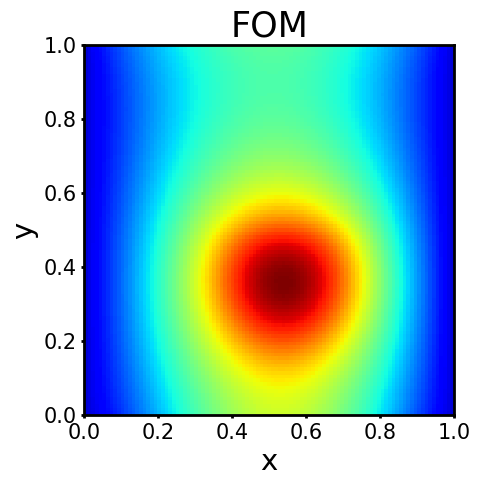

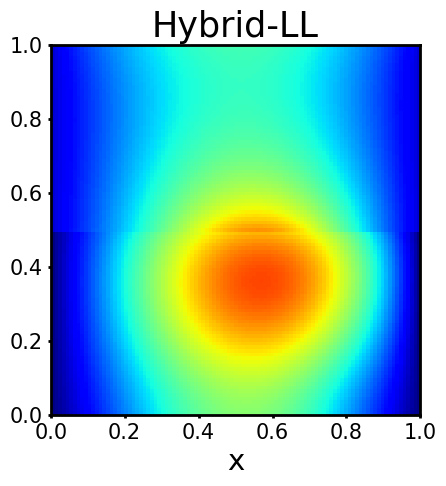

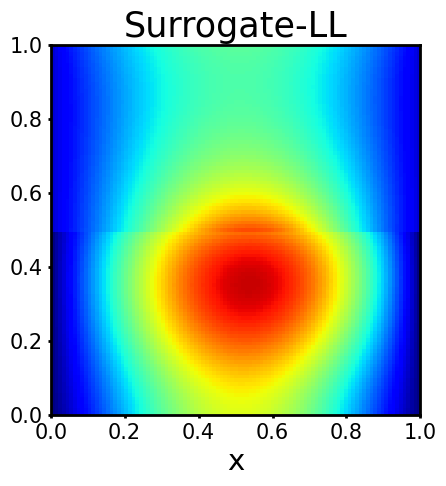

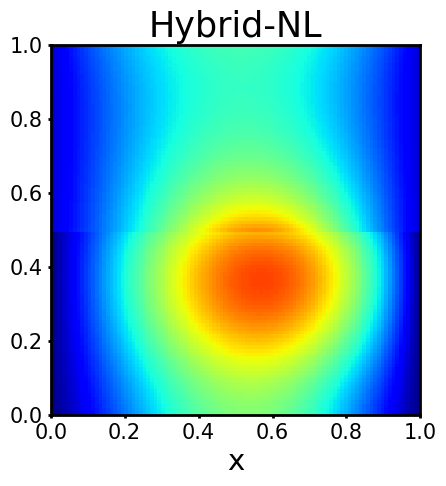

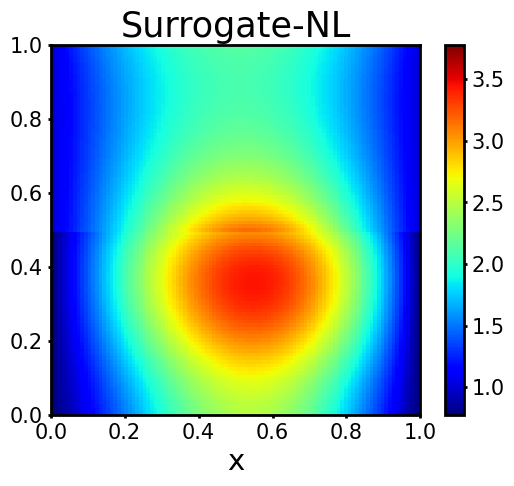

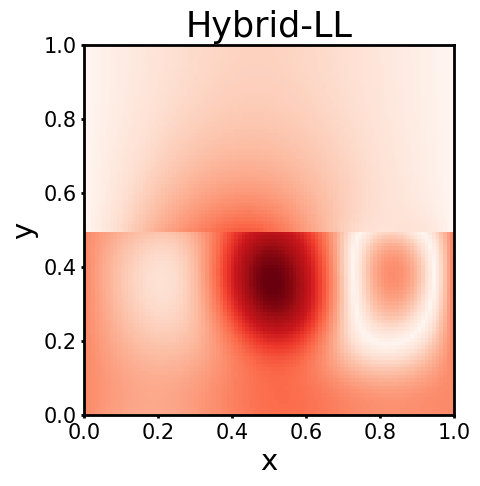

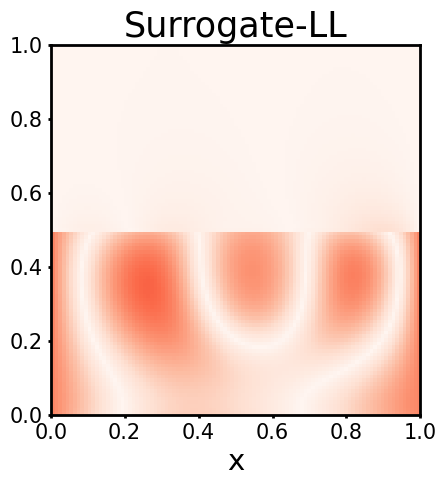

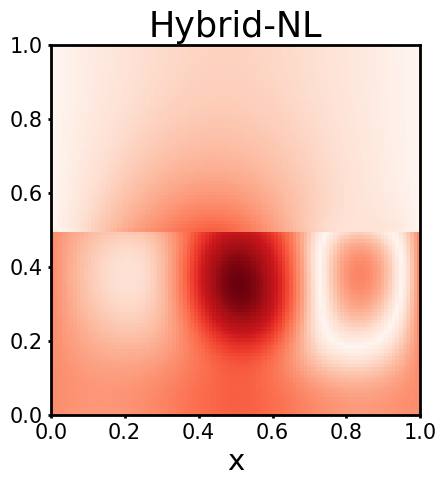

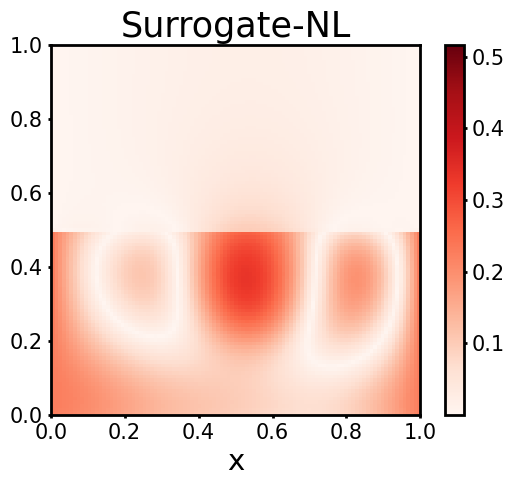

In [20]:
# Choose index between 0 and ntest ----------- 
index = 5

print('Relative error domain 1 method 1',rel_d1_m1[index])
print('Relative error domain 2 method 1',rel_d2_m1[index])

print('Relative error domain I method 1',rel_dI_m1[index])
print('Relative error domain all method 1',rel_all_m1[index])

print('Relative error domain 1 method 2',rel_d1_m2[index])
print('Relative error domain 2 method 2',rel_d2_m2[index])

print('Relative error domain I method 2',rel_dI_m2[index])
print('Relative error domain all method 2',rel_all_m2[index])

print('Relative error domain 1 method 3',rel_d1_m3[index])
print('Relative error domain 2 method 3',rel_d2_m3[index])

print('Relative error domain I method 3',rel_dI_m3[index])
print('Relative error domain all method 3',rel_all_m3[index])

print('Relative error domain 1 method 4',rel_d1_m4[index])
print('Relative error domain 2 method 4',rel_d2_m4[index])

print('Relative error domain I method 4',rel_dI_m4[index])
print('Relative error domain all method 4',rel_all_m4[index])

fig0 = block_to_fig(S[:,index+nsamples-ntest],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig1 = block_to_fig(sol_m1[index,:],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig2 = block_to_fig(sol_m2[index,:],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig3 = block_to_fig(sol_m3[index,:],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig4 = block_to_fig(sol_m4[index,:],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)

figs = [fig0, fig1, fig2, fig3, fig4]

vmax = -10
vmin = 10

for figure in figs:

    maxcandidate = max(figure.flatten())
    mincandidate = min(figure.flatten())

    if maxcandidate > vmax:
        vmax = maxcandidate

    if mincandidate < vmin:
        vmin = mincandidate 
        
titles = ['FOM', 'Hybrid-LL', 'Surrogate-LL', 'Hybrid-NL', 'Surrogate-NL']
saves = ['FOM2', 'HL2', 'SL2','HN2', 'SN2']
saves_error = ['HL2e', 'SL2e','HN2e', 'SN2e']

# ----------------------------------- FOM and ROMs
for i in range(5):
    
    plt.figure(figsize=(6.4, 4.8))
    plt.imshow(figs[i] , vmin=vmin, vmax=vmax, interpolation = "nearest",extent=[0,1,0,1], cmap='jet')
    
    if i ==4:
        plt.colorbar()
    plt.title(titles[i])   
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')
#     plt.savefig(saves[i], bbox_inches='tight')
    plt.show()
    
# ----------------------------------- Absolute errors
fig1 = block_to_fig(abs(sol_m1[index,:]-S[:,index+nsamples-ntest]),rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig2 = block_to_fig(abs(sol_m2[index,:]-S[:,index+nsamples-ntest]),rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig3 = block_to_fig(abs(sol_m3[index,:]-S[:,index+nsamples-ntest]),rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig4 = block_to_fig(abs(sol_m4[index,:]-S[:,index+nsamples-ntest]),rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)

figs = [fig1, fig2, fig3, fig4]

vmax = -10
vmin = 10

for figure in figs:

    maxcandidate = max(figure.flatten())
    mincandidate = min(figure.flatten())

    if maxcandidate > vmax:
        vmax = maxcandidate

    if mincandidate < vmin:
        vmin = mincandidate 
        
titles = ['Hybrid-LL', 'Surrogate-LL','Hybrid-NL', 'Surrogate-NL']

for i in range(4):
    plt.figure(figsize=(6.4, 4.8))
    plt.imshow(figs[i] , vmin=vmin, vmax=vmax, interpolation = "nearest",extent=[0,1,0,1], cmap='Reds')
    
    if i ==3:
        plt.colorbar()
    plt.title(titles[i])   
    
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')
#     plt.savefig(saves_error[i], bbox_inches='tight')
    plt.show()



# Relative error figure

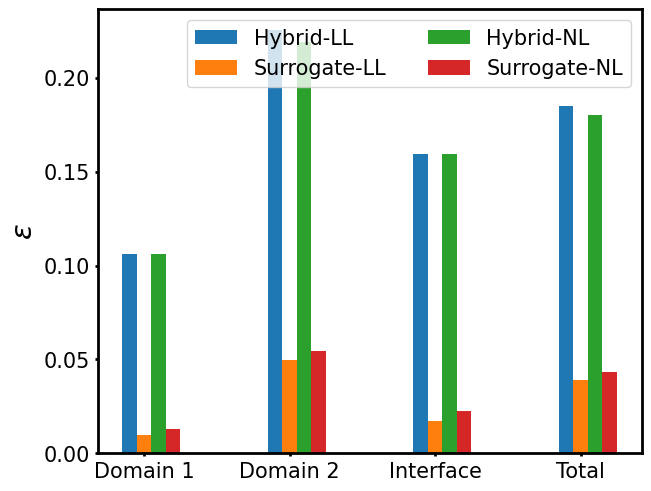

In [21]:
species = ("Domain 1", "Domain 2", "Interface", "Total")
penguin_means = {
    
    'Hybrid-LL': (np.mean(rel_d1_m1), np.mean(rel_d2_m1), np.mean(rel_dI_m1), np.mean(rel_all_m1)),
    'Surrogate-LL': (np.mean(rel_d1_m2), np.mean(rel_d2_m2), np.mean(rel_dI_m2), np.mean(rel_all_m2)),
    
    'Hybrid-NL': (np.mean(rel_d1_m3), np.mean(rel_d2_m3), np.mean(rel_dI_m3), np.mean(rel_all_m3)),
    'Surrogate-NL': (np.mean(rel_d1_m4), np.mean(rel_d2_m4), np.mean(rel_dI_m4), np.mean(rel_all_m4)),
}

x = np.arange(len(species))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('$\epsilon$')
ax.set_xticks(x + width, species)

ax.legend(loc='upper right', ncols=2)
plt.savefig('relativerrorsp.png', bbox_inches='tight')
plt.show()

# Online CPU

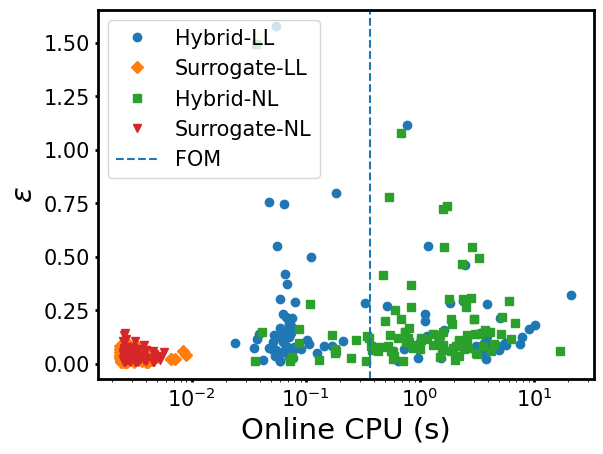

In [22]:
fig = plt.plot(online_m1, rel_all_m1, 'o', color='tab:blue', label='Hybrid-LL')
plt.plot(online_m2, rel_all_m2, 'D', color='tab:orange', label='Surrogate-LL')

plt.plot(online_m3, rel_all_m3, 's', color='tab:green', label='Hybrid-NL')
plt.plot(online_m4, rel_all_m4, 'v', color='tab:red', label='Surrogate-NL')
plt.axvline(x=online_FOM, linestyle='dashed', label='FOM')

plt.xlabel("Online CPU (s)")
plt.ylabel("$\epsilon$")
plt.xscale('log')

plt.legend(loc='upper left')
plt.savefig('onlinep.png', bbox_inches='tight')
plt.show()